# 1. Implemetation of `Identify Functional Groups` algorithm.

> The algorithm was developed by **Peter Ertl** ([paper](https://jcheminf.biomedcentral.com/articles/10.1186/s13321-017-0225-z)). The algorithm was originally implemented using the Novartis in-house cheminformatics system written in Java. **Richard Hall** and **Guillaume Godin** later Implemented it in python with RDKit. The code can be found at [here](https://github.com/rdkit/rdkit/tree/master/Contrib/IFG).

## Algorithm:
 - Mark all heteroatoms in a molecule, including halogens.
 - Mark four specific **carbon** atoms:
     - atoms connected by non-aromatic double or triple bond to any heteroatom.
     - atoms in nonaromatic carbon-carbon double or triple bonds
     - acetal carbons, *i.e.,* `sp3` carbons connected to two or more oxygens, nitrogens or sulfurs; there `O`, `N`, `S` atoms mush have only single bonds.
     - all atoms in oxirane, aziridine and thiirane rings (such rings are traditionally considered to be functional groups due to their high reactivity).
 - Merge all connected marked atoms to a single functional group (FG).
 - Extract FGs also with connected unmarked carbon atoms, these carbon atoms are not part of the FG itself, but form its enviroment.

In [1]:
from rdkit import Chem
from collections import namedtuple

from rdkit.Chem import Draw
from rdkit.Chem.Draw import IPythonConsole

RDKit WARNING: [10:33:08] Enabling RDKit 2019.09.2 jupyter extensions


In [1]:
def merge(mol, marked, aset):
    bset = set()
    for idx in aset:
        atom = mol.GetAtomWithIdx(idx)
        for nbr in atom.GetNeighbors():
            jdx = nbr.GetIdx()
            if jdx in marked:
                marked.remove(jdx)
                bset.add(jdx)
    if not bset:
        return
    merge(mol, marked, bset)
    aset.update(bset)

# atoms connected by non-aromatic double or triple bond to any heteroatom
# c=O should not match (see fig1, box 15).  I think using A instead of * should sort that out?
PATT_DOUBLE_TRIPLE = Chem.MolFromSmarts('A=,#[!#6]')
# atoms in non aromatic carbon-carbon double or triple bonds
PATT_CC_DOUBLE_TRIPLE = Chem.MolFromSmarts('C=,#C')
# acetal carbons, i.e. sp3 carbons connected to tow or more oxygens, nitrogens or sulfurs; these O, N or S atoms must have only single bonds
PATT_ACETAL = Chem.MolFromSmarts('[CX4](-[O,N,S])-[O,N,S]')
# all atoms in oxirane, aziridine and thiirane rings
PATT_OXIRANE_ETC = Chem.MolFromSmarts('[O,N,S]1CC1')

PATT_TUPLE = (PATT_DOUBLE_TRIPLE, PATT_CC_DOUBLE_TRIPLE, PATT_ACETAL, PATT_OXIRANE_ETC)
    
def identify_functional_groups(mol):
    marked = set()
#mark all heteroatoms in a molecule, including halogens
    for atom in mol.GetAtoms():
        if atom.GetAtomicNum() not in (6,1): # would we ever have hydrogen?
            marked.add(atom.GetIdx())

#mark the four specific types of carbon atom
    for patt in PATT_TUPLE:
        for path in mol.GetSubstructMatches(patt):
            for atomindex in path:
                marked.add(atomindex)

#merge all connected marked atoms to a single FG
    groups = []
    while marked:
        grp = set([marked.pop()])
        merge(mol, marked, grp)
        groups.append(grp)

#extract also connected unmarked carbon atoms
    ifg = namedtuple('IFG', ['atomIds', 'atoms', 'type'])
    ifgs = []
    for g in groups:
        uca = set()
        for atomidx in g:
            for n in mol.GetAtomWithIdx(atomidx).GetNeighbors():
                if n.GetAtomicNum() == 6:
                    uca.add(n.GetIdx())
        ifgs.append(ifg(atomIds=tuple(list(g)), atoms=Chem.MolFragmentToSmiles(mol, g, canonical=True), type=Chem.MolFragmentToSmiles(mol, g.union(uca),canonical=True)))
    return ifgs

NameError: name 'Chem' is not defined

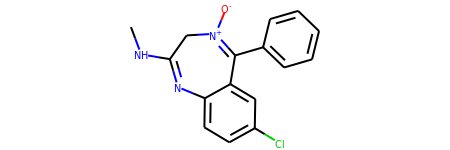

In [3]:
#test 
smiles = 'CNC1=Nc2ccc(Cl)cc2C(=N(=O)C1)c3ccccc3'
mol = Chem.MolFromSmiles(smiles)
mol

In [4]:
fgs = identify_functional_groups(mol)

The result is a list of FGs. Each FG is a three-term tuple `(atom ID, SMILES of FG, SMILES of FG with enviroment)`. 

In [5]:
fgs

[IFG(atomIds=(1, 2, 3), atoms='N=CN', type='cN=C(C)NC'),
 IFG(atomIds=(8,), atoms='Cl', type='cCl'),
 IFG(atomIds=(11, 12, 13), atoms='C=[N+][O-]', type='cC(c)=[N+](C)[O-]')]

The generated SMILES are not always be able to convert back to RDKit Mol.

In [40]:
Chem.MolFromSmiles(fgs[0].type)

RDKit ERROR: [10:36:25] non-ring atom 0 marked aromatic


The above code does not cover the `generalization scheme` (see below) proposed originally by **Ertl**. **ToNorberto Sánchez-Cruz** further completed the [code](https://github.com/DIFACQUIM/IFG_General) with a fragmentation approach considering the retainment of parent carbons and hydrogens proposed originally, were the remaining carbon atoms are replaced by dummy atoms. This implementation works over a SMILES string and returns a list with the canonical SMILES of the FGs identified in the molecule. 

> FGs, particularly those with several connection points, may be present in numerous forms differing by varia- tion in their environment. The attachment points may be unsubstituted (i.e. the valences are filled by hydrogens) or connected to aliphatic or aromatic carbons with large number of possible combinations. 

> E.g., a simple amide group with 3 connection points may form 18 such variations (two connections on nitrogen are considered to be symmetrical here). 

> It would be desirable to merge FGs based on the important “central” moiety.

In [41]:
# Based on the work of Richard Hall and Guillaume Godin
# Additions or modifications are indicated with ##

from rdkit import Chem
from rdkit.Chem import rdmolops

def merge(mol, marked, aset):
    bset = set()
    for idx in aset:
        atom = mol.GetAtomWithIdx(idx)
        for nbr in atom.GetNeighbors():
            jdx = nbr.GetIdx()
            if jdx in marked:
                marked.remove(jdx)
                bset.add(jdx)
    if not bset:
        return
    merge(mol, marked, bset)
    aset.update(bset)

## Heteroatoms connected to an aliphatic atom (by single, double or triple bond), to avoid single aromatic heteroatoms
PATT_HETERO = Chem.MolFromSmarts("[!#6;!#1]")
# atoms connected by non-aromatic double or triple bond to any heteroatom
# c=O should not match (see fig1, box 15).  I think using A instead of * should sort that out?
## Using C explicitly indicates non-aromatic carbons, we changed this beacuse we use explicit hydrogens in the molecule, that would be matched by A 
PATT_DOUBLE_TRIPLE = Chem.MolFromSmarts('C=,#[!#6]')
# atoms in non aromatic carbon-carbon double or triple bonds
PATT_CC_DOUBLE_TRIPLE = Chem.MolFromSmarts('C=,#C')
# acetal carbons, i.e. sp3 carbons connected to tow or more oxygens, nitrogens or sulfurs; these O, N or S atoms must have only single bonds
PATT_ACETAL = Chem.MolFromSmarts('[CX4](-[O,N,S])-[O,N,S]')
# all atoms in oxirane, aziridine and thiirane rings
PATT_OXIRANE_ETC = Chem.MolFromSmarts('[O,N,S]1CC1')

PATT_TUPLE = (PATT_HETERO, PATT_DOUBLE_TRIPLE, PATT_CC_DOUBLE_TRIPLE, PATT_ACETAL, PATT_OXIRANE_ETC)

def identify_functional_groups_gs(smi):
    ## We decided to start from a SMILES and add explicit hydrogens inside the function
    mol = Chem.MolFromSmiles(smi)
    mol = rdmolops.AddHs(mol)
    try:
        marked = set()
    ## Since heteroatoms are included in PATT_TUPLE, we remove the first part of the original function 
        for patt in PATT_TUPLE:
            for path in mol.GetSubstructMatches(patt):
                for atomindex in path:
                    marked.add(atomindex)

    #merge all connected marked atoms to a single FG
        groups = []
        while marked:
            grp = set([marked.pop()])
            merge(mol, marked, grp)
            groups.append(grp)
        groups = [list(x) for x in groups]
        
    ## It seems that the initial filtering of heteroatoms was not enough, so we add this to remove groups with only aromatic atoms
        for g in groups:
            group_aromaticity = set([mol.GetAtomWithIdx(idx).GetIsAromatic() for idx in g])
            if group_aromaticity == {True}:
                groups.remove(g)
        
    ## Identify bonds to break and hydrogens to keep for every FG
        bonds = []
        labels = []
        for g in groups:
            group_bonds = []
            group_labels = []
            for idx in g:
                atom = mol.GetAtomWithIdx(idx)
                
                ## Carbon atoms
                if atom.GetAtomicNum() == 6:
                    for nbr in atom.GetNeighbors():
                        ## Carbonyl groups to disciminate between aldehydes and ketones
                        if nbr.GetAtomicNum() == 8 and str(mol.GetBondBetweenAtoms(idx,nbr.GetIdx()).GetBondType()) == "DOUBLE":
                            PreserveH = True
                            break
                        else:
                            PreserveH = False
                    if PreserveH == True:
                        for nbr in atom.GetNeighbors():
                            jdx = nbr.GetIdx()
                            if jdx not in g and nbr.GetAtomicNum() != 1:
                                group_bonds.append(mol.GetBondBetweenAtoms(idx,jdx).GetIdx())
                                group_labels.append((0,0))
                    else:
                        for nbr in atom.GetNeighbors():
                            jdx = nbr.GetIdx()
                            if jdx not in g:
                                group_bonds.append(mol.GetBondBetweenAtoms(idx,jdx).GetIdx())
                                group_labels.append((0,0))
                ## Nitrogen atoms
                elif atom.GetAtomicNum() == 7:
                    ## To discriminate between anilines and amines (primary, secondary, etc)
                    if len(g) == 1:
                        neigh_atn = [x.GetAtomicNum() for x in atom.GetNeighbors() if x.GetAtomicNum() != 1]
                        if neigh_atn.count(6) == 1:
                            for nbr in atom.GetNeighbors():
                                jdx = nbr.GetIdx()
                                if jdx not in g and nbr.GetAtomicNum() != 1:
                                    group_bonds.append(mol.GetBondBetweenAtoms(idx,jdx).GetIdx())
                                    if nbr.GetIsAromatic() == True:
                                        group_labels.append((1,1))
                                    else:
                                        group_labels.append((0,0))
                        else:
                            for nbr in atom.GetNeighbors():
                                jdx = nbr.GetIdx()
                                if jdx not in g and nbr.GetAtomicNum() != 1:
                                    group_bonds.append(mol.GetBondBetweenAtoms(idx,jdx).GetIdx())
                                    group_labels.append((0,0))
                    else:
                        for nbr in atom.GetNeighbors():
                            jdx = nbr.GetIdx()
                            if jdx not in g:
                                group_bonds.append(mol.GetBondBetweenAtoms(idx,jdx).GetIdx())
                                group_labels.append((0,0))

                ## Oxygen atoms
                elif atom.GetAtomicNum() == 8:
                    ## To discriminate between alcohols from phenols and esthers from carboxylic acids
                    if len(g) == 1:
                        neigh_atn = [x.GetAtomicNum() for x in atom.GetNeighbors() if x.GetAtomicNum() != 1]
                        if len(neigh_atn) == 1 and neigh_atn.count(6) == 1:
                            for nbr in atom.GetNeighbors():
                                jdx = nbr.GetIdx()
                                if jdx not in g and (nbr.GetAtomicNum() != 1):
                                    group_bonds.append(mol.GetBondBetweenAtoms(idx,jdx).GetIdx())
                                    if nbr.GetIsAromatic() == True:
                                        group_labels.append((1,1))
                                    else:
                                        group_labels.append((0,0))
                        else:
                            for nbr in atom.GetNeighbors():
                                jdx = nbr.GetIdx()
                                if jdx not in g and nbr.GetAtomicNum() != 1:
                                    group_bonds.append(mol.GetBondBetweenAtoms(idx,jdx).GetIdx())
                                    group_labels.append((0,0))                        
                    else:
                        for nbr in atom.GetNeighbors():
                            jdx = nbr.GetIdx()
                            if jdx not in g and nbr.GetAtomicNum() != 1:
                                group_bonds.append(mol.GetBondBetweenAtoms(idx,jdx).GetIdx())
                                group_labels.append((0,0))

                ## Sulfur atoms
                elif atom.GetAtomicNum() == 16:
                    if len(g) == 1:
                        for nbr in atom.GetNeighbors():
                            jdx = nbr.GetIdx()
                            if jdx not in g and nbr.GetAtomicNum() != 1:
                                group_bonds.append(mol.GetBondBetweenAtoms(idx,jdx).GetIdx())
                                group_labels.append((0,0))
                    else:
                        for nbr in atom.GetNeighbors():
                            jdx = nbr.GetIdx()
                            if jdx not in g:
                                group_bonds.append(mol.GetBondBetweenAtoms(idx,jdx).GetIdx())
                                group_labels.append((0,0))

                else:               
                    for nbr in atom.GetNeighbors():
                        jdx = nbr.GetIdx()
                        if jdx not in g:
                            group_bonds.append(mol.GetBondBetweenAtoms(idx,jdx).GetIdx())
                            group_labels.append((0,0))
            labels.append(group_labels)
            bonds.append(group_bonds)

    ## Build final fragments
        FGS_ENVS = []
        for i in range(len(groups)):
            Frag = Chem.FragmentOnBonds(mol,bonds[i], dummyLabels = labels[i])
            Frags = rdmolops.GetMolFrags(Frag)
            for j in Frags:
                if groups[i][0] in j:
                    FGS_ENVS.append(Chem.MolFragmentToSmiles(Frag, j, canonical=True, allHsExplicit=True))
        FGS_ENVS = list(set(FGS_ENVS))
        for i in FGS_ENVS:
            if Chem.MolFromSmiles(i) == None:
                FG = Chem.MolFromSmarts(i)
            else:
                FG = Chem.MolFromSmiles(i)
            if set([atom.GetIsAromatic() for atom in FG.GetAtoms() if atom.GetSymbol() not in ["*","H"]]) == {True}:
                FGS_ENVS.remove(i)
        return FGS_ENVS 
    
    except:
        ## When the molecules is as small as a single FG
        FGS_ENVS = [Chem.MolToSmiles(mol, canonical=True, allHsExplicit=True)]
        return FGS_ENVS

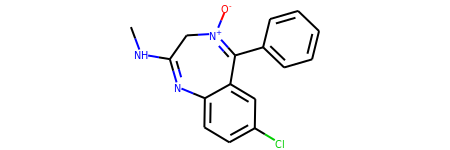

In [42]:
mol

In [43]:
gs_fgs = identify_functional_groups_gs(smiles)

In [44]:
gs_fgs

['[*][N]=[C]([*])[N]([*])[*]', '[*][C]([*])=[N+]([*])[O-]', '[*][Cl]']

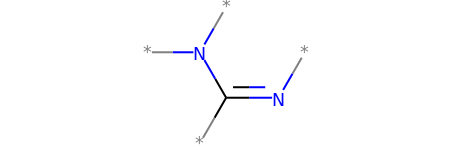

In [45]:
Chem.MolFromSmiles(gs_fgs[0])

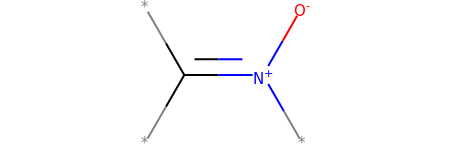

In [46]:
Chem.MolFromSmiles(gs_fgs[1])

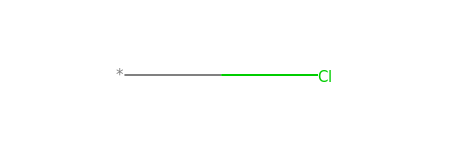

In [47]:
Chem.MolFromSmiles(gs_fgs[2])

Merge the codes. The new code will output a list of FGs. Each FGs are represented by a four-term tuple: `(atom ID, SMILES of FG, SMILES of FG with enviroment, SMILES of FG with generalized scheme)`

## Visualization with highlights of FGs 

In [12]:
from io import BytesIO
from PIL import Image
from rdkit.Chem import rdDepictor
from rdkit.Chem.Draw import rdMolDraw2D

def _prepareMol(mol,kekulize):
    mc = Chem.Mol(mol.ToBinary())
    if kekulize:
        try:
            Chem.Kekulize(mc)
        except:
            mc = Chem.Mol(mol.ToBinary())
    if not mc.GetNumConformers():
        rdDepictor.Compute2DCoords(mc)
    return mc

def moltopng(mol,molSize=(450,200),kekulize=True,drawer=None,**kwargs):
    mc = _prepareMol(mol,kekulize)
    if drawer is None:
        drawer = rdMolDraw2D.MolDraw2DCairo(molSize[0],molSize[1])
    drawer.DrawMolecule(mc,**kwargs)
    drawer.FinishDrawing()
    sio = BytesIO(drawer.GetDrawingText())
    return Image.open(sio)

We want to highlights the FGs with different colors according to their types. The colors are defined by the [Python Color Constants Module](https://www.webucator.com/blog/2015/03/python-color-constants-module/).

In [13]:
def collect_highlights(fgs):
    highlight_atoms = []
    highlight_colors = {}
    
    colors = [
    (0.50,0.55,0.55), # azure4 for C=C and C#C,
    (0.5,1,0), # chartreuse1 for halogens,
    (0.1,0.55,1), #dodgerblue1 for FG contains only N and/or C,
    (1,0.7,0.75), # deeppink1 for FG contains O but not S.
    (1,0.93,0.55) # lightgoldenrod1 for FG contains S
    ]
    
    for fg in fgs:
        highlight_atoms += list(fg.atomIds)
        
        if 'C' in fg.atoms or 'c' in fg.atoms:
            color = colors[0]
        if 'F' in fg.atoms or 'Cl' in fg.atoms or 'Br' in fg.atoms or 'I' in fg.atoms:
            color = colors[1]
        if 'N' in fg.atoms or 'n' in fg.atoms:
            color = colors[2]
        if 'O' in fg.atoms or 'o' in fg.atoms:
            color = colors[3]
        if 'S' in fg.atoms or 's' in fg.atoms:
            color = colors[4]
        
        for atomID in fg.atomIds:
            highlight_colors[atomID] = color
    return highlight_atoms, highlight_colors

In [14]:
    colors = [
    (131,139,139), # azure4 for C=C and C#C,
    (127,255,0), # chartreuse1 for halogens,
    (30,144,255), #dodgerblue1 for FG contains only N and/or C,
    (255,20,147), # lightpink for FG contains O but not S.
    (255,236,139) # lightgoldenrod1 for FG contains S
    ]

In [15]:
#test 
smiles = 'CNC1=Nc2ccc(Cl)cc2C(=N(=O)C1)c3ccccc3'
mol = Chem.MolFromSmiles(smiles)
fgs = identify_functional_groups(mol)

FG_atoms, FG_colors = collect_highlights(fgs)


In [16]:
fgs

[IFG(atomIds=(1, 2, 3), atoms='N=CN', type='cN=C(C)NC'),
 IFG(atomIds=(8,), atoms='Cl', type='cCl'),
 IFG(atomIds=(11, 12, 13), atoms='C=[N+][O-]', type='cC(c)=[N+](C)[O-]')]

The `default` highligh: all FGs are highlight in the same color.

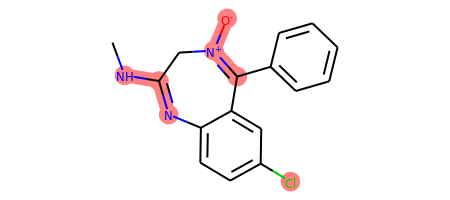

In [17]:
moltopng(mol,highlightAtoms=FG_colors)

Highlight FGs according to the FG types. Bonds in the FGs are not highlighted. 

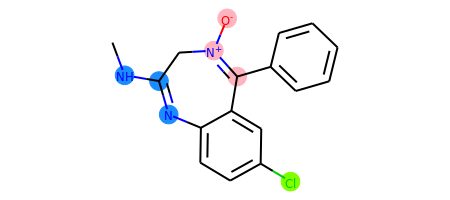

In [18]:
moltopng(mol,highlightAtoms=FG_atoms, highlightBonds = [], highlightAtomColors=FG_colors, highlightBondColors=FG_colors)

**Issue**: The bonds in FGs are not highlighted in the same color as atoms.

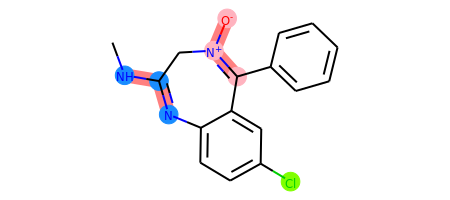

In [19]:
moltopng(mol,highlightAtoms=FG_atoms, highlightAtomColors=FG_colors)

Highlight the bond color will generate **wrong** highlights. 

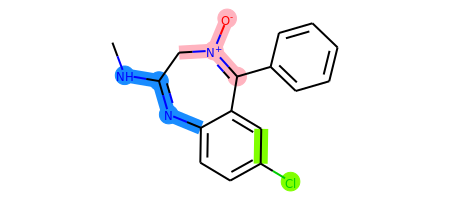

In [20]:
moltopng(mol,highlightAtoms=FG_atoms, highlightBonds = FG_atoms, highlightAtomColors=FG_colors, highlightBondColors=FG_colors)

## 2. Mask FGs in the SMILES

### Method 1: Remove the FGs from the original molecules

Some useful code:
 - http://www.rdkit.org/docs/GettingStartedInPython.html#chemical-transformations

In [21]:
#test 
smiles = 'CNC1=Nc2ccc(Cl)cc2C(=N(=O)C1)c3ccccc3'
mol = Chem.MolFromSmiles(smiles)
fgs = identify_functional_groups(mol)

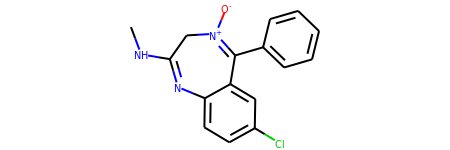

In [22]:
mol

In [23]:
fgs

[IFG(atomIds=(1, 2, 3), atoms='N=CN', type='cN=C(C)NC'),
 IFG(atomIds=(8,), atoms='Cl', type='cCl'),
 IFG(atomIds=(11, 12, 13), atoms='C=[N+][O-]', type='cC(c)=[N+](C)[O-]')]

Remove the functional group `C=[N+][O-]` from the molecule.

In [24]:
fg = Chem.MolFromSmarts('C=[N+][O-]')

In [25]:
reduced_mol = Chem.ReplaceCore(mol,fg)

This results in two molecular fragments.

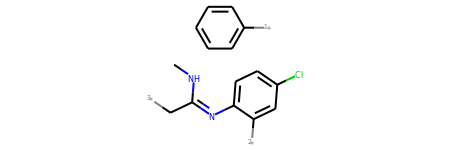

In [26]:
reduced_mol

`rdkit.Chem.rdmolops.ReplaceCore()` returns the fragments in a single molecule. The fragments can be split into separate molecules using `rdkit.Chem.rdmolops.GetMolFrags()` :

In [27]:
rs = Chem.GetMolFrags(reduced_mol,asMols=True)

In [28]:
len(rs)

2

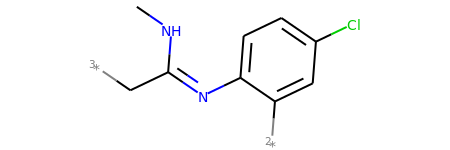

In [29]:
rs[0]

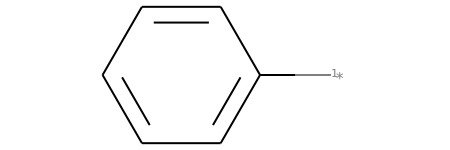

In [30]:
rs[1]

Convert the molecular fragments to SMILES

In [31]:
Chem.MolToSmiles(reduced_mol)

'[1*]c1ccccc1.[2*]c1cc(Cl)ccc1N=C(C[3*])NC'

In [32]:
Chem.MolToSmiles(rs[0])

'[2*]c1cc(Cl)ccc1N=C(C[3*])NC'

In [33]:
Chem.MolToSmiles(rs[1])

'[1*]c1ccccc1'

Note: when convert the `reduced_mol` to SMILES, the *character order* of the SMILES is different from the original SMILES of `mol`.

In [34]:
Chem.MolToSmiles(mol)

'CNC1=Nc2ccc(Cl)cc2C(c2ccccc2)=[N+]([O-])C1'

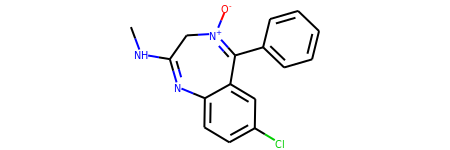

In [35]:
smiles = 'Clc1ccc2c(c1)C(c1ccccc1)=[N+]([O-])CC(NC)=N2'
mol = Chem.MolFromSmiles(smiles)
mol